Optimization completed.
Optimal centroids: 
[[6.60431366 3.14748182 5.71491407 1.94358223]
 [4.94992272 3.48593252 1.47791709 0.23941622]
 [6.21426745 2.73606109 4.50054059 1.34919071]]
Best SSE score: 89.11149267965664
Silhouette Score: 0.5518177421032635, Davies-Bouldin Score: 0.6645635038257798
MAE: 0.0933
Accuracy: 0.9067
Precision: 0.9213
Recall: 0.9067
F1 Score: 0.9053


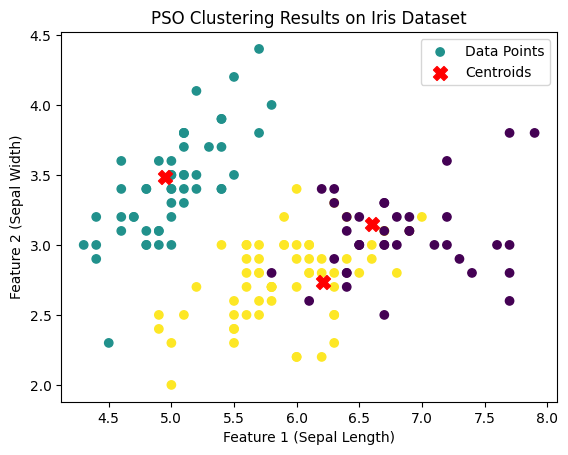

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from scipy.stats import mode


# --- Configuration Section ---
class Config:
    PARTICLES = 50
    ITERATIONS = 200
    W_INITIAL = 1.0
    W_FINAL = 0.3
    C1 = 1.3
    C2 = 2.1
    CLUSTERS = 3  # Iris dataset has 3 clusters
    DATA_POINTS = 150  # Iris dataset has 150 data points


# --- PSO Parameters Class ---
class PSOParameters:
    def __init__(self, particles=Config.PARTICLES, iterations=Config.ITERATIONS, w_initial=Config.W_INITIAL, w_final=Config.W_FINAL, c1=Config.C1, c2=Config.C2, K=Config.CLUSTERS):
        self.particles = particles
        self.iterations = iterations
        self.w_initial = w_initial
        self.w_final = w_final
        self.c1 = c1
        self.c2 = c2
        self.K = K


# --- Data Loading Function for Iris Dataset ---
def load_data():
    iris = load_iris()
    data = iris.data  # 150 samples with 4 features
    labels = iris.target  # True labels for evaluation
    return data, labels


# --- PSO Clustering Implementation ---
class PSOClustering:
    def __init__(self, data, params):
        self.data = data
        self.params = params
        self.num_features = data.shape[1]
        # Ensure centroids are initialized within the data range to prevent premature convergence
        data_min = np.min(data, axis=0)
        data_max = np.max(data, axis=0)
        self.positions = data_min + np.random.rand(params.particles, params.K, self.num_features) * (data_max - data_min)
        self.velocities = np.random.rand(params.particles, params.K, self.num_features) * 0.1
        self.pbest_positions = np.copy(self.positions)
        self.pbest_scores = np.full(params.particles, np.inf)
        self.gbest_position = None
        self.gbest_score = np.inf


    def _calculate_fitness(self, centroids):
        clusters = np.argmin(np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2), axis=1)
        sse = np.sum(np.linalg.norm(self.data - centroids[clusters], axis=1) ** 2)
        return sse


    def run(self):
        for iteration in range(self.params.iterations):
            w = self.params.w_initial - ((self.params.w_initial - self.params.w_final) * (iteration / self.params.iterations))
            for i in range(self.params.particles):
                fitness_value = self._calculate_fitness(self.positions[i])
                if fitness_value < self.pbest_scores[i]:
                    self.pbest_scores[i] = fitness_value
                    self.pbest_positions[i] = self.positions[i]
                if fitness_value < self.gbest_score:
                    self.gbest_score = fitness_value
                    self.gbest_position = self.positions[i]
            for i in range(self.params.particles):
                r1, r2 = np.random.rand(), np.random.rand()
                self.velocities[i] = (w * self.velocities[i] +
                                      self.params.c1 * r1 * (self.pbest_positions[i] - self.positions[i]) +
                                      self.params.c2 * r2 * (self.gbest_position - self.positions[i]))
                self.positions[i] += self.velocities[i]


        print("Optimization completed.")
        return self.gbest_position, self.gbest_score


# --- Evaluation and Validation ---
def evaluate_clustering(data, centroids):
    clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    # Check if there are at least 2 unique clusters before calculating Silhouette Score
    if len(np.unique(clusters)) > 1:
        silhouette_avg = silhouette_score(data, clusters)
        davies_bouldin = davies_bouldin_score(data, clusters)
        print(f"Silhouette Score: {silhouette_avg}, Davies-Bouldin Score: {davies_bouldin}")
        return silhouette_avg, davies_bouldin
    else:
        print("Silhouette Score cannot be calculated: Only one cluster found.")
        return None, None  # or return appropriate values


def evaluate_classification_metrics(data, centroids, true_labels):
    clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    mapped_labels = np.zeros_like(clusters)
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        mapped_labels[mask] = mode(true_labels[mask], keepdims=True).mode[0]
    metrics = {
        "MAE": mean_absolute_error(true_labels, mapped_labels),
        "Accuracy": accuracy_score(true_labels, mapped_labels),
        "Precision": precision_score(true_labels, mapped_labels, average='macro'),
        "Recall": recall_score(true_labels, mapped_labels, average='macro'),
        "F1 Score": f1_score(true_labels, mapped_labels, average='macro')
    }
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    return metrics


def plot_clusters(data, centroids):
    clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', label="Data Points")  # Only plotting the first 2 features
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=100, label="Centroids")
    plt.title("PSO Clustering Results on Iris Dataset")
    plt.xlabel("Feature 1 (Sepal Length)")
    plt.ylabel("Feature 2 (Sepal Width)")
    plt.legend()
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    data, true_labels = load_data()
    pso_params = PSOParameters()
    pso_clustering = PSOClustering(data, pso_params)
    centroids, score = pso_clustering.run()
    print(f"Optimal centroids: \n{centroids}")
    print(f"Best SSE score: {score}")

    evaluate_clustering(data, centroids)
    evaluate_classification_metrics(data, centroids, true_labels)
    plot_clusters(data, centroids)


